In [1]:
%cd /isilon/data/users/jpfeife2/jetAnomalyDetection

/isilon/data/users/jpfeife2/jetAnomalyDetection


In [2]:
from format_data import format_2D
from models import Autoencoder, train_model, Transformer, SmallAutoencoder
from torch.optim import Adam
from torch.nn import MSELoss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np 
from data_analysis import plot_property_distribution, plot_property_distribution2
# from torchsummary import summary
from torchinfo import summary
import torch
import constants as c
import pandas as pd 
from model_analysis import plot_loss, plot_anomaly_score, plot_roc
import glob 
import os
from matplotlib.colors import TwoSlopeNorm
import matplotlib.colors as mcolors


In [3]:
print(c.BINS)

32


In [4]:
batch_size = 20
epochs = 8
initial_lr = 0.001
weight_decay = 1e-3
latent_dim = 12


In [5]:
background_label = "qcd400to500"
signal_label = "hbb400to500"
props = ['dzErr']
data_dir = "/isilon/data/users/jpfeife2/AutoEncoder-Anomaly-Detection/processed_data"
n_props = len(props)
prop_string = ''.join(['_' + str(prop) for prop in props])


In [6]:
print("Data Loading ...")
background = np.load(data_dir + "/" + background_label + prop_string + ".npy", allow_pickle=True).reshape(-1, c.BINS, c.BINS, n_props)
signal = np.load(data_dir + "/" + signal_label + prop_string + ".npy", allow_pickle=True).reshape(-1, c.BINS, c.BINS, n_props)

print("Background events: ", len(background))
print("Signal events: ", len(signal))
train_data, test_data = train_test_split(background, test_size = 0.2)

input_shape = train_data.shape
n_props = input_shape[-1]
print(input_shape)

X_train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
X_test_dataloader = DataLoader(test_data, batch_size=10, shuffle=False)
X_valid_dataloader = DataLoader(signal, batch_size=10, shuffle=False)

print("Data Loaded!")



Data Loading ...


Background events:  118845
Signal events:  4377
(95076, 32, 32, 1)
Data Loaded!


In [7]:
print(len(background[0]))

32


In [8]:
# background2 = [p for sublist in background[:500] for subsublist in sublist for p in subsublist ]
# anom2 = [p for sublist in signal[:500] for subsublist in sublist for p in subsublist ]

# plot_property_distribution2(background2, anom2, 'dz/dzErr', 'qcd', 'hbb')

In [9]:


#=============== Define Model =========
# model = Autoencoder(input_shape)
# model =SmallAutoencoder(input_shape, latent_dim=latent_dim)

model = Transformer(input_size = input_shape, latent_dim=latent_dim)
# optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
optimizer = Adam(model.parameters(), lr = initial_lr)

summary(model, input_size=(batch_size, c.BINS, c.BINS, n_props))

criterion = MSELoss(reduction='mean')


/isilon/data/users/jpfeife2/miniforge3/envs/anomaly/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [10]:

#=============== Run Model =========
print("Training Model... ")
torch.set_num_threads(3)
train_loss, test_loss, signal_loss = train_model(
    train_dataloader = X_train_dataloader, 
    test_dataloader = X_test_dataloader, 
    signal_dataloader= X_valid_dataloader,
    model = model, 
    loss_fn = MSELoss(reduction='mean'), 
    optimizer = optimizer, 
    epochs = epochs, 
    batch_size = batch_size )

torch.save(model, "model")

Training Model... 


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [05:40<00:00, 42.58s/it]


In [11]:
loss_fn = MSELoss()
test_loss = model.background_test_loss 
anomaly_loss = model.signal_loss
test_data_list = model.test_data
anomaly_data_list = model.signal_data


In [12]:
# Convert losses to numpy arrays for easier manipulation
test_loss = np.array(test_loss)
anomaly_loss = np.array(anomaly_loss)

Analyzing Results... 


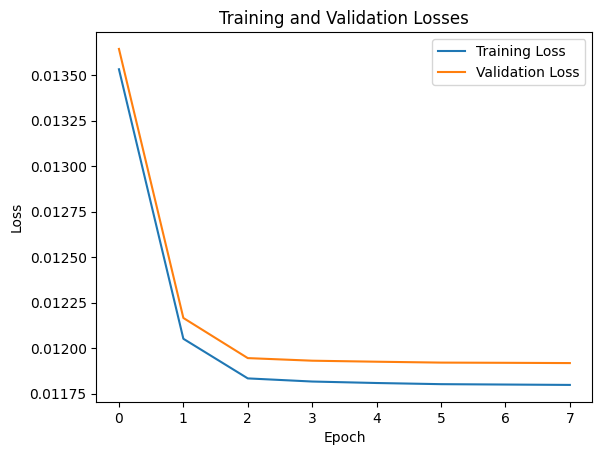

<Figure size 640x480 with 0 Axes>

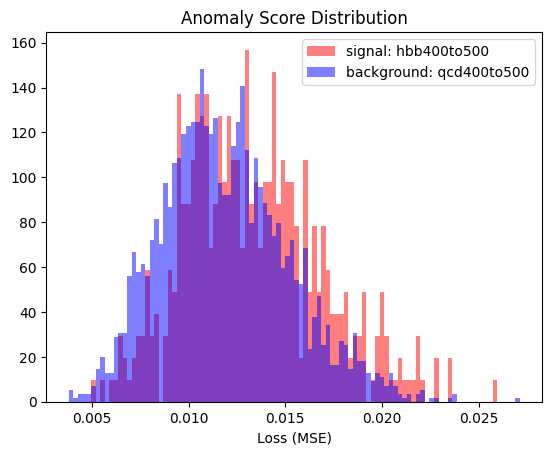

<Figure size 640x480 with 0 Axes>

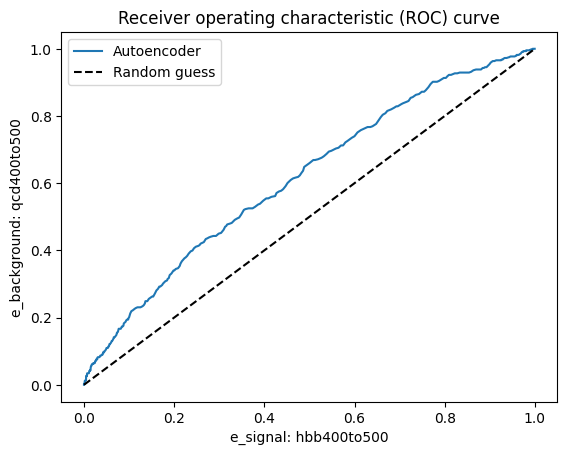

AUC: 0.615
Done!


<Figure size 640x480 with 0 Axes>

In [13]:
#============== Save Analysis========
print("Analyzing Results... ")
plot_loss(model.train_hist, model.val_hist)
plot_anomaly_score(model.background_test_loss, model.signal_loss, background_label, signal_label)
plot_roc(model, signal_label, background_label, examples=False, loss_fn=MSELoss(reduction='mean'), properties=props)

# print("TRAIN HIST \n", model.train_hist)
# print("VAL HIST \n", model.val_hist)
print("Done!")

In [14]:
print(c.BINS)

32


In [15]:
test_idx = np.where(test_loss < np.percentile(test_loss, [5])[0])[0]

# Find indices where maximum anomaly loss is higher than the maximum test loss
anomaly_idx = np.where(anomaly_loss >  np.percentile(anomaly_loss, [95])[0])[0]
# print(test_idx)
print(len(anomaly_idx))
print(len(anomaly_loss))
print(np.percentile(anomaly_loss, [0.05])[0])

22
438
0.005169572637882084


In [16]:
def find_extrema(idx, data_list, find_max_extrema): 
    vals = [] 
    fn = MSELoss()
    losses = []
    plots = []
    to_plot = []


    for x, i in enumerate(idx): 
        vals.append(0.0)
        losses.append(0.0 if find_max_extrema else np.inf)
        plots.append(0.0)
        lossi = 0.0 if find_max_extrema else np.inf
        batch = data_list[i]
        for jet in batch: 
            m = jet.reshape(-1, c.BINS, c.BINS, 1)
            reco = model(m)[0]
            
            loss = fn(m, reco)
            if (find_max_extrema and loss > lossi) or (not find_max_extrema and loss < lossi):
                lossi = loss 
                losses[x] = float(loss)
                plots[x] = (m[0])

                m_data = np.array(m.flatten())
                m_data = m_data[m_data != 0]
                vals[x] = [y for y in m_data]
                to_plot.append(m_data)
    return vals, losses, plots, to_plot

In [17]:
def plot_extrema(to_plot, data_type): 
    num_plots = len(to_plot)
    fig, axes = plt.subplots(1, num_plots, figsize=(5*num_plots, 5))
    for ax, p in zip(axes, to_plot): 
        r = (-10, 10)
        ax.hist(p, bins=150, edgecolor='black', range = r)
        ax.set_xlim(-10, 10)
        ax.set_ylim(0, 3.5)
        ax.set_xlabel(data_type)
        ax.set_ylabel('Frequency')
    plt.suptitle('Example of '+ data_type, fontsize=25)
    plt.show()

In [18]:
def plot_extrema_2(to_plot, norm, label): 
    plots = to_plot[:10]
    num_plots = len(plots)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))
    for ax, p in zip(axes, plots):
        ax.imshow(p, norm=norm)
        ax.axis('off')  
    plt.suptitle(label, fontsize=45)

    plt.show()

In [19]:
dz_anom_vals, dz_anom_losses, dz_anom_plots, dz_anom_to_plot = find_extrema(anomaly_idx, anomaly_data_list, find_max_extrema = True)
dz_background_vals, dz_background_losses, dz_background_plots, dz_background_to_plot = find_extrema(test_idx, test_data_list, find_max_extrema = False)

/isilon/data/users/jpfeife2/miniforge3/envs/anomaly/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 32, 1])) that is different to the input size (torch.Size([1, 32, 32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


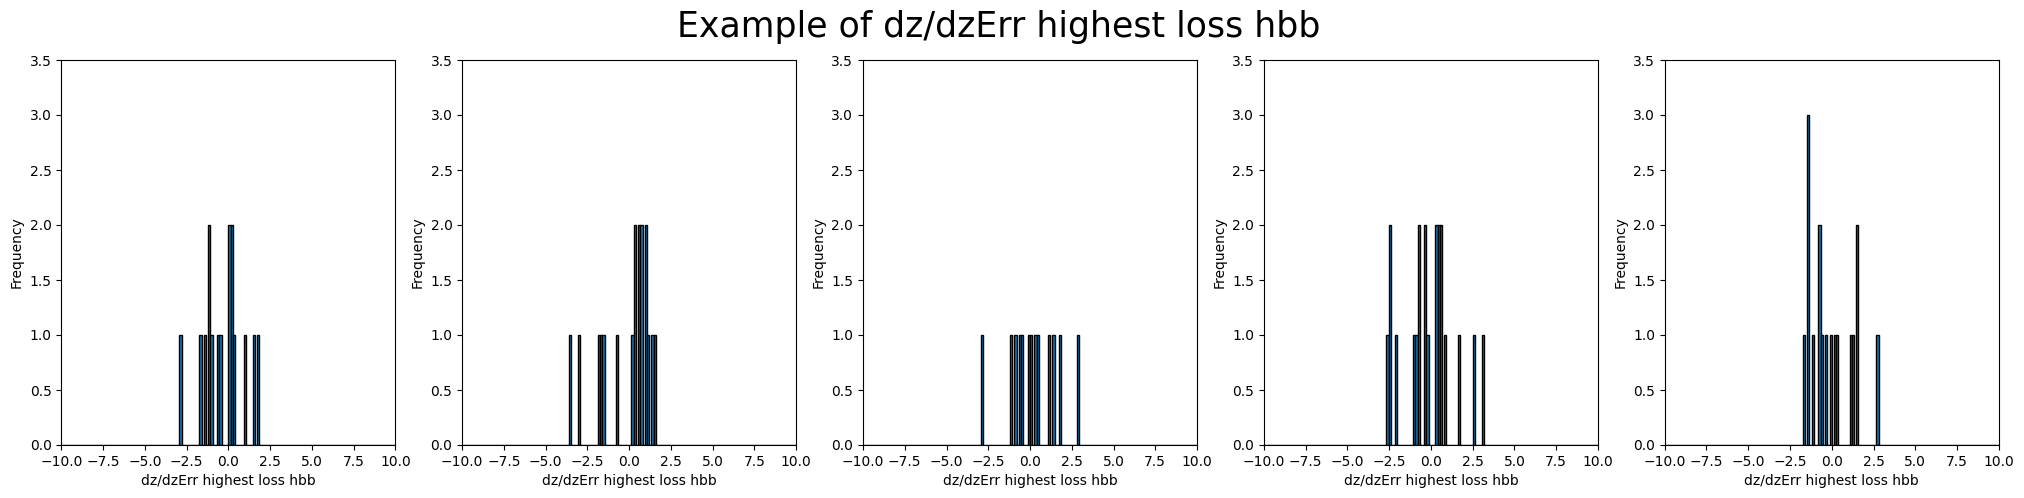

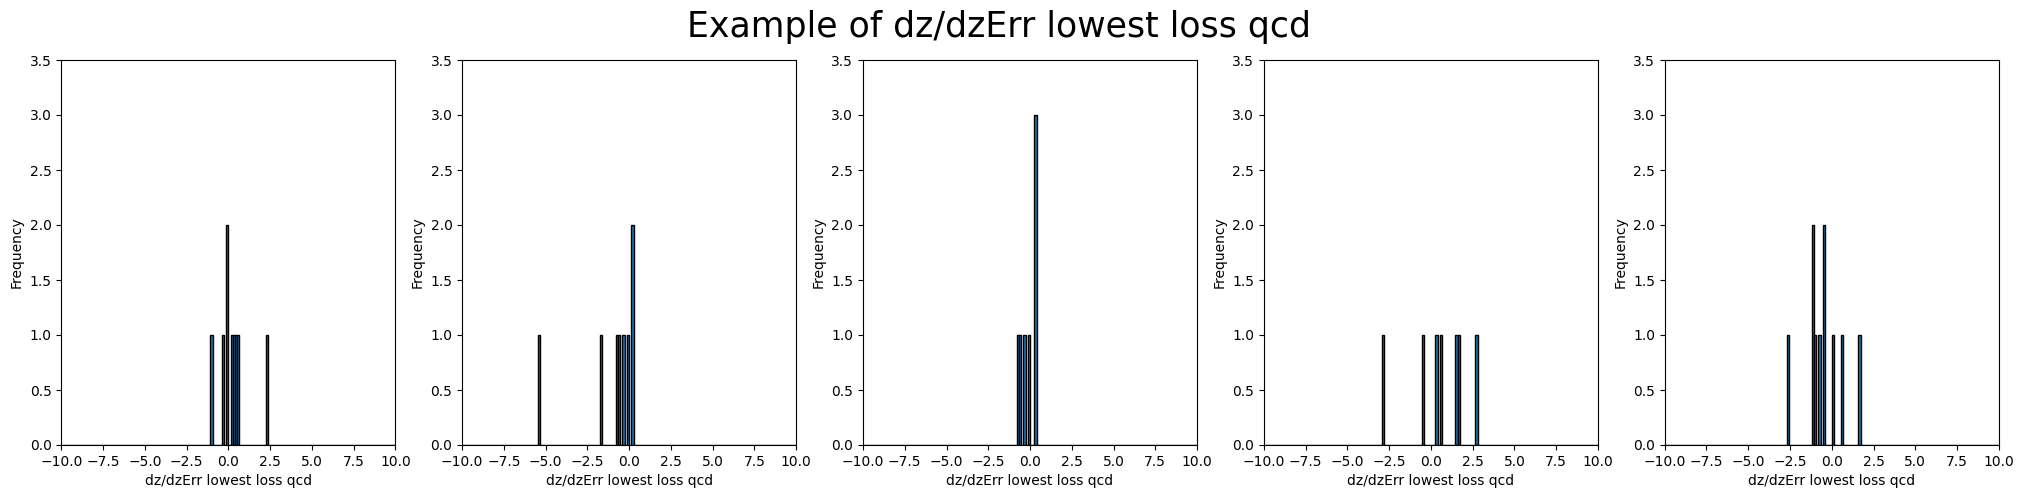

In [20]:
plot_extrema(dz_anom_to_plot[:5], "dz/dzErr highest loss hbb")
plot_extrema(dz_background_to_plot[7:7+5], "dz/dzErr lowest loss qcd")

In [21]:
dz_anom_plot_vals = [p for sublist in dz_anom_plots[:10] for p in sublist]
dz_background_plot_vals = [p for sublist in dz_background_plots[:10] for p in sublist]

cmap = plt.cm.viridis 
max_val = np.max([np.max(dz_anom_plot_vals), np.max(dz_background_plot_vals)])
min_val = np.min([np.min(dz_anom_plot_vals), np.min(dz_background_plot_vals)]) 
abs_max = np.max(np.abs([max_val, min_val]))
print(max_val, min_val)
print(abs_max)

norm = mcolors.Normalize(vmin=-abs_max, vmax=abs_max)

7.164707 -4.0865374
7.164707


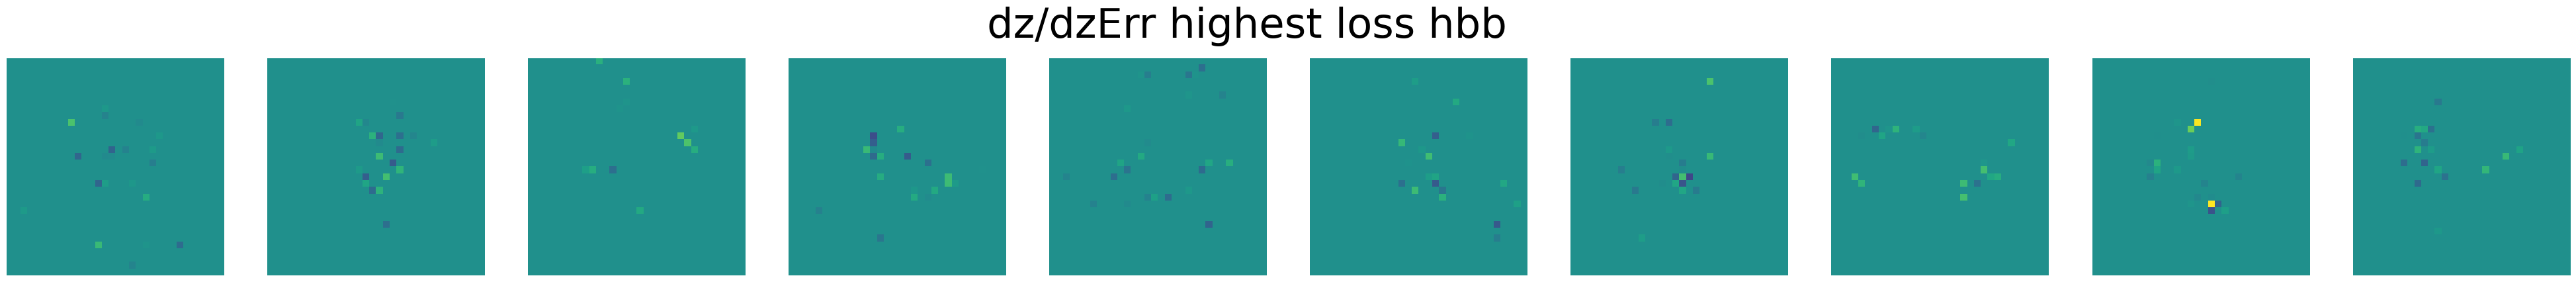

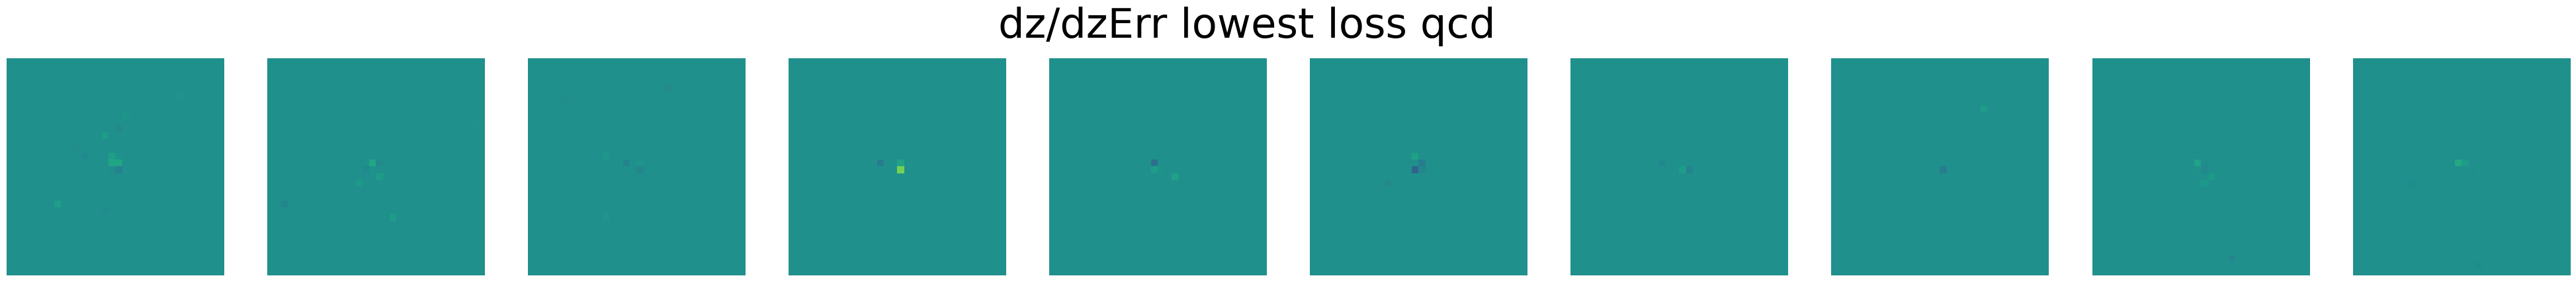

In [22]:
plot_extrema_2(dz_anom_plots, norm, "dz/dzErr highest loss hbb")
plot_extrema_2(dz_background_plots, norm, "dz/dzErr lowest loss qcd")

In [23]:
dz_anom_vals = [d for sublist in dz_anom_vals for d in sublist]
dz_background_vals = [d for sublist in dz_background_vals for d in sublist]

In [24]:
def plot_property_distribution2(background_data, signal_data, prop_name, background_label, signal_label):
    fig, ax = plt.subplots()
    ax.set_title("Distribution of " + prop_name + " extrema" )
    ax.set_xlabel(prop_name)

    bins = 150

    bin_range = (np.min([np.min(background_data), np.min(signal_data)]),
            np.max([np.max(background_data), np.max(signal_data)]))
    
    ax.hist(background_data, density=True, label=background_label, alpha=0.5, bins=bins, range=bin_range)
    ax.hist(signal_data, density=True, label=signal_label, alpha=0.5, bins=bins, range=bin_range)
    plt.legend()
    plt.show()

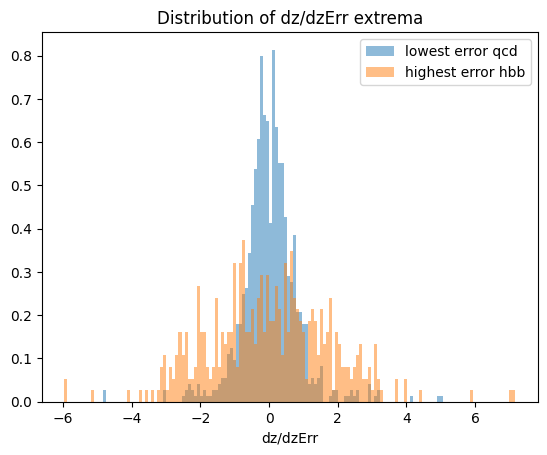

In [25]:
plot_property_distribution2(dz_background_vals, dz_anom_vals, 'dz/dzErr', 'lowest error qcd', 'highest error hbb')

In [26]:
background_label = "qcd400to500"
signal_label = "hbb400to500"
props = ['d0Err']
n_props = len(props)
prop_string = ''.join(['_' + str(prop) for prop in props])


data_dir = "/isilon/data/users/jpfeife2/AutoEncoder-Anomaly-Detection/processed_data"
print("Data Loading ...")
background = np.load(data_dir + "/" + background_label + prop_string + ".npy", allow_pickle=True).reshape(-1, c.BINS, c.BINS, n_props)
signal = np.load(data_dir + "/" + signal_label + prop_string + ".npy", allow_pickle=True).reshape(-1, c.BINS, c.BINS, n_props)

print("Background events: ", len(background))
print("Signal events: ", len(signal))
train_data, test_data = train_test_split(background, test_size = 0.2)
input_shape = train_data.shape
n_props = input_shape[-1]
print(input_shape)
print(signal.shape)

X_train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
X_test_dataloader = DataLoader(test_data, batch_size=10, shuffle=False)
X_valid_dataloader = DataLoader(signal, batch_size=10, shuffle=False)

print("Data Loaded!")



Data Loading ...
Background events:  475380
Signal events:  17508
(380304, 32, 32, 1)
(17508, 32, 32, 1)
Data Loaded!


In [27]:
background2 = [p for sublist in background for p in sublist]
anom2 = [p for sublist in signal for p in sublist]

# plot_property_distribution2(background2, anom2, 'd0/d0Err', 'qcd', 'hbb')

In [28]:


#=============== Define Model =========
# model = Autoencoder(input_shape)
# model =SmallAutoencoder(input_shape, latent_dim=latent_dim)
# optimizer = Adam(model.parameters(), lr = initial_lr)

model = Transformer(input_size = input_shape, latent_dim=latent_dim)
optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=weight_decay)

summary(model, input_size=(batch_size, c.BINS, c.BINS, n_props))

criterion = MSELoss(reduction='mean')


/isilon/data/users/jpfeife2/miniforge3/envs/anomaly/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [29]:

#=============== Run Model =========
print("Training Model... ")
torch.set_num_threads(3)
train_loss, test_loss, signal_loss = train_model(
    train_dataloader = X_train_dataloader, 
    test_dataloader = X_test_dataloader, 
    signal_dataloader= X_valid_dataloader,
    model = model, 
    loss_fn = MSELoss(reduction='mean'), 
    optimizer = optimizer, 
    epochs = epochs, 
    batch_size = batch_size )

torch.save(model, "model")

Training Model... 


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [20:01<00:00, 150.19s/it]


Analyzing Results... 


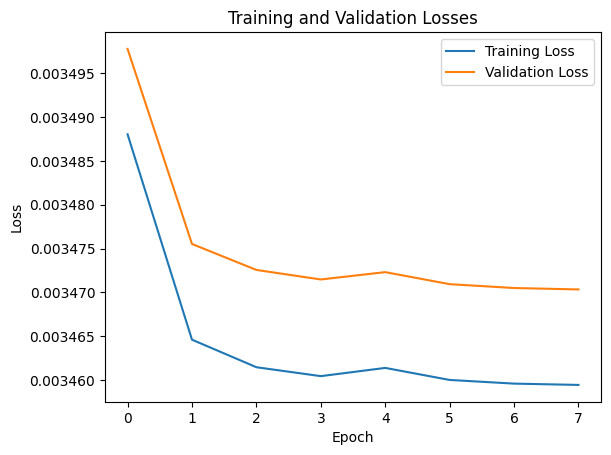

<Figure size 640x480 with 0 Axes>

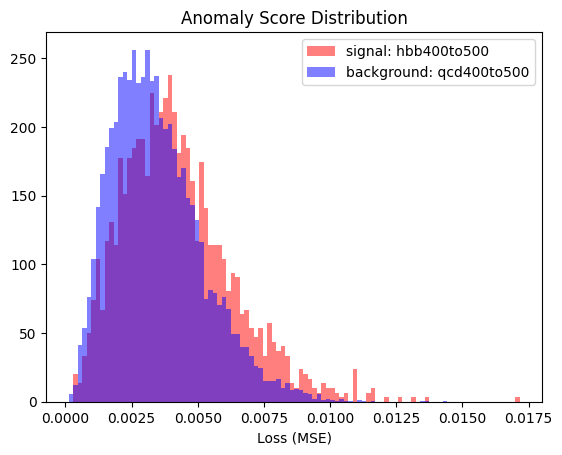

<Figure size 640x480 with 0 Axes>

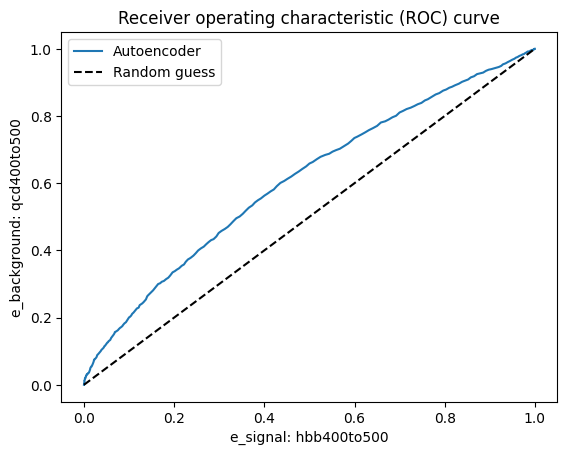

AUC: 0.608
Done!


<Figure size 640x480 with 0 Axes>

In [30]:
#============== Save Analysis========
print("Analyzing Results... ")
plot_loss(model.train_hist, model.val_hist)
plot_anomaly_score(model.background_test_loss, model.signal_loss, background_label, signal_label)
plot_roc(model, signal_label, background_label, examples=False, loss_fn=MSELoss(reduction='mean'), properties=props)

# print("TRAIN HIST \n", model.train_hist)
# print("VAL HIST \n", model.val_hist)
print("Done!")

In [31]:
loss_fn = MSELoss()
test_loss = model.background_test_loss 
anomaly_loss = model.signal_loss
test_data_list = model.test_data
anomaly_data_list = model.signal_data


In [32]:
# Convert losses to numpy arrays for easier manipulation
test_loss = np.array(test_loss)
anomaly_loss = np.array(anomaly_loss)

In [33]:
test_idx = np.where(test_loss < np.percentile(test_loss, [5])[0])[0]

# Find indices where maximum anomaly loss is higher than the maximum test loss
anomaly_idx = np.where(anomaly_loss >  np.percentile(anomaly_loss, [95])[0])[0]
# print(test_idx)
# print(anomaly_idx)

In [34]:
d0_anom_vals, d0_anom_losses, d0_anom_plots, d0_anom_to_plot = find_extrema(anomaly_idx, anomaly_data_list, find_max_extrema=True)
d0_background_vals, d0_background_losses, d0_background_plots, d0_background_to_plot = find_extrema(test_idx, test_data_list, find_max_extrema=False)

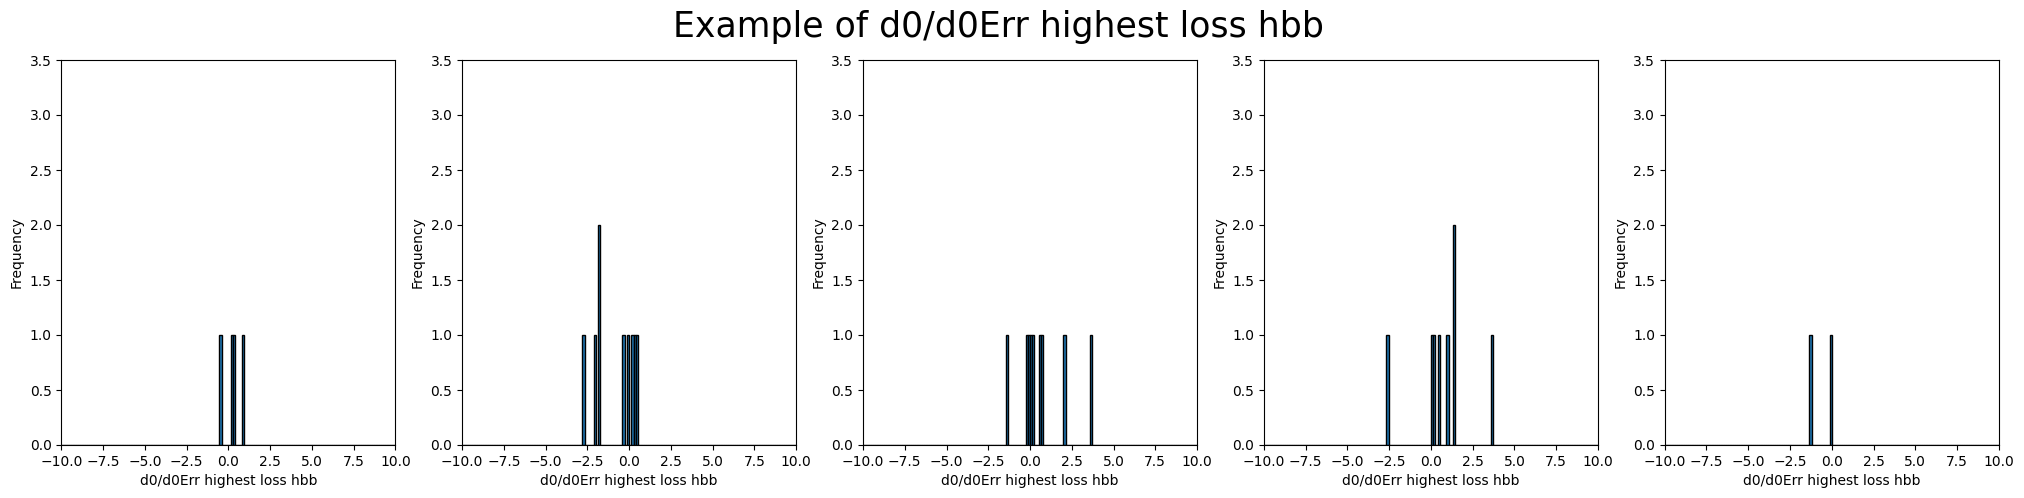

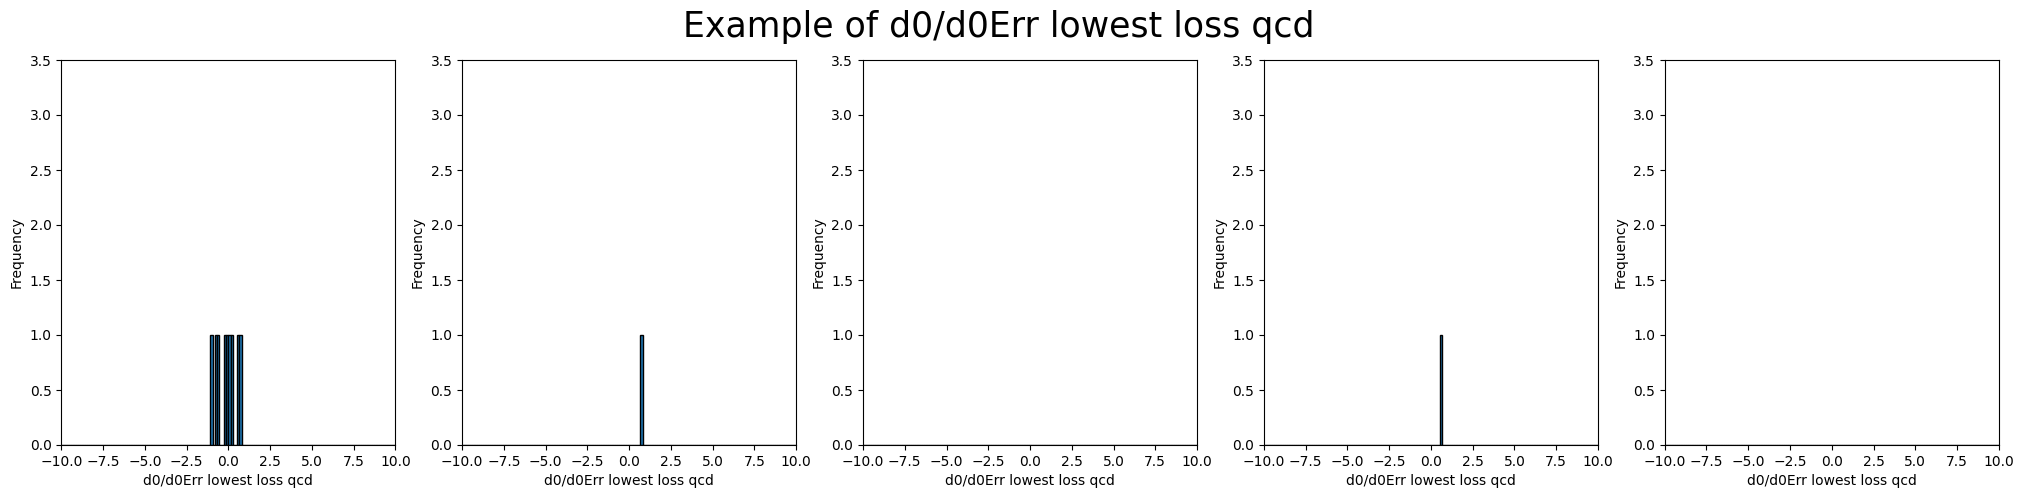

In [35]:
plot_extrema(d0_anom_to_plot[:5], "d0/d0Err highest loss hbb")
plot_extrema(d0_background_to_plot[:5], "d0/d0Err lowest loss qcd")

In [36]:
d0_anom_plot_vals = [p for sublist in d0_anom_plots[:10] for p in sublist]
d0_background_plot_vals = [p for sublist in d0_background_plots[:10] for p in sublist]

cmap = plt.cm.viridis 
max_val = np.max([np.max(d0_anom_plot_vals), np.max(d0_background_plot_vals)])
min_val = np.min([np.min(d0_anom_plot_vals), np.min(d0_background_plot_vals)]) 

norm = mcolors.Normalize(vmin=min_val, vmax=max_val)

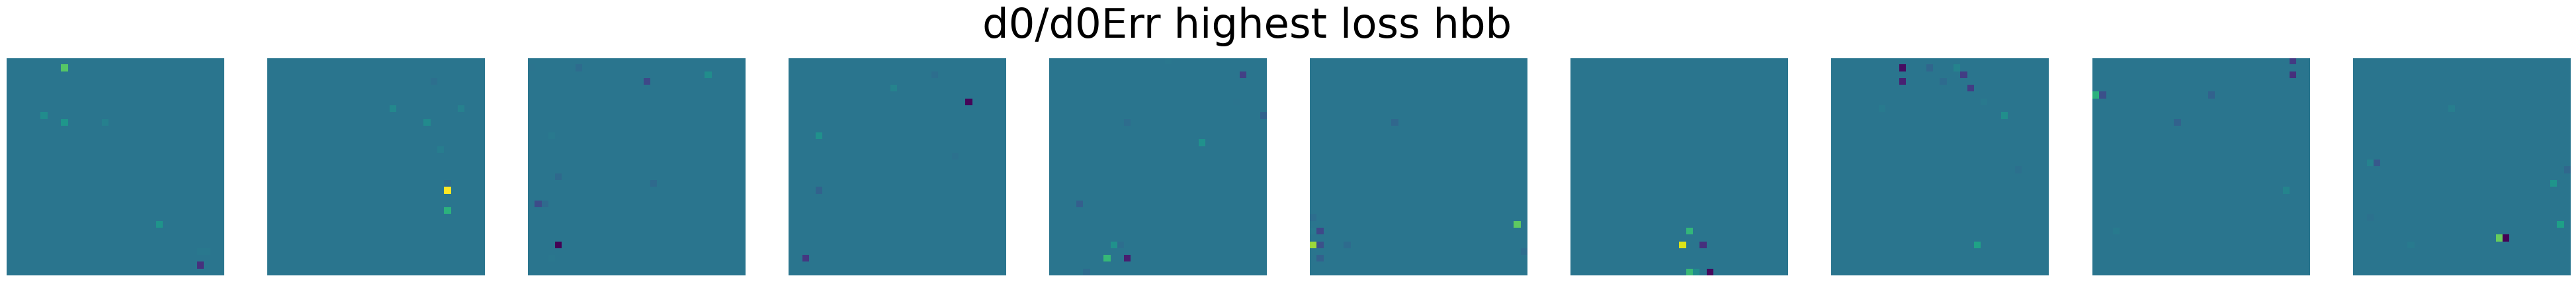

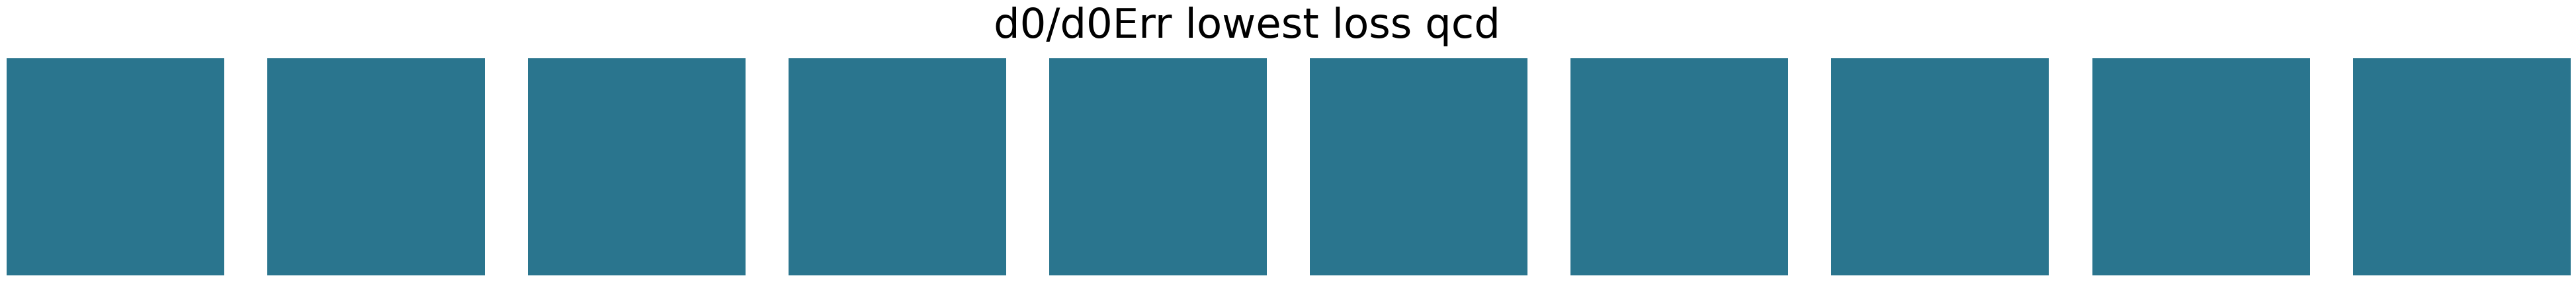

In [37]:
plot_extrema_2(d0_anom_plots, norm, "d0/d0Err highest loss hbb")
plot_extrema_2(d0_background_plots, norm, "d0/d0Err lowest loss qcd")

In [38]:
dz_anom_plot_vals = [p for sublist in dz_anom_plots[:10] for p in sublist]
dz_background_plot_vals = [p for sublist in dz_background_plots[:10] for p in sublist]
d0_anom_plot_vals = [p for sublist in d0_anom_plots[:10] for p in sublist]
d0_background_plot_vals = [p for sublist in d0_background_plots[:10] for p in sublist]

cmap = plt.cm.viridis 
max_val = np.max([np.max(dz_anom_plot_vals), np.max(dz_background_plot_vals), np.max(d0_anom_plot_vals), np.max(d0_background_plot_vals)])
min_val = np.min([np.min(dz_anom_plot_vals), np.min(dz_background_plot_vals), np.min(d0_anom_plot_vals), np.min(d0_background_plot_vals)]) 
abs_max = np.max(np.abs([max_val, min_val]))
print(max_val, min_val)
print(abs_max)

norm = mcolors.Normalize(vmin=-abs_max, vmax=abs_max)

7.164707 -4.1345377
7.164707


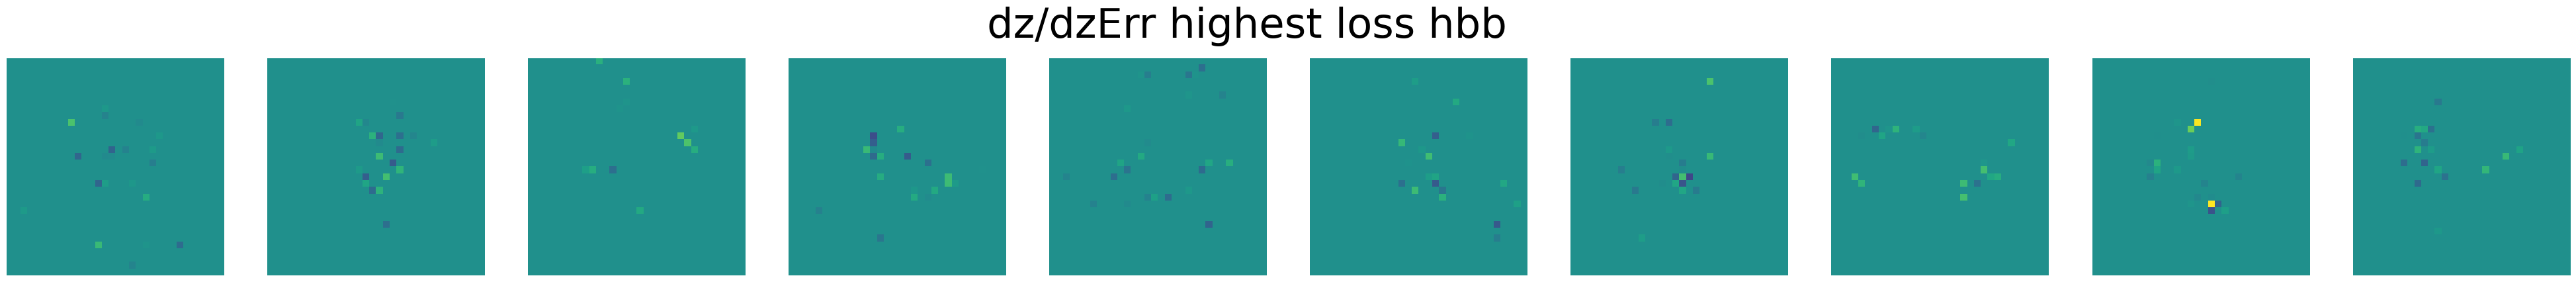

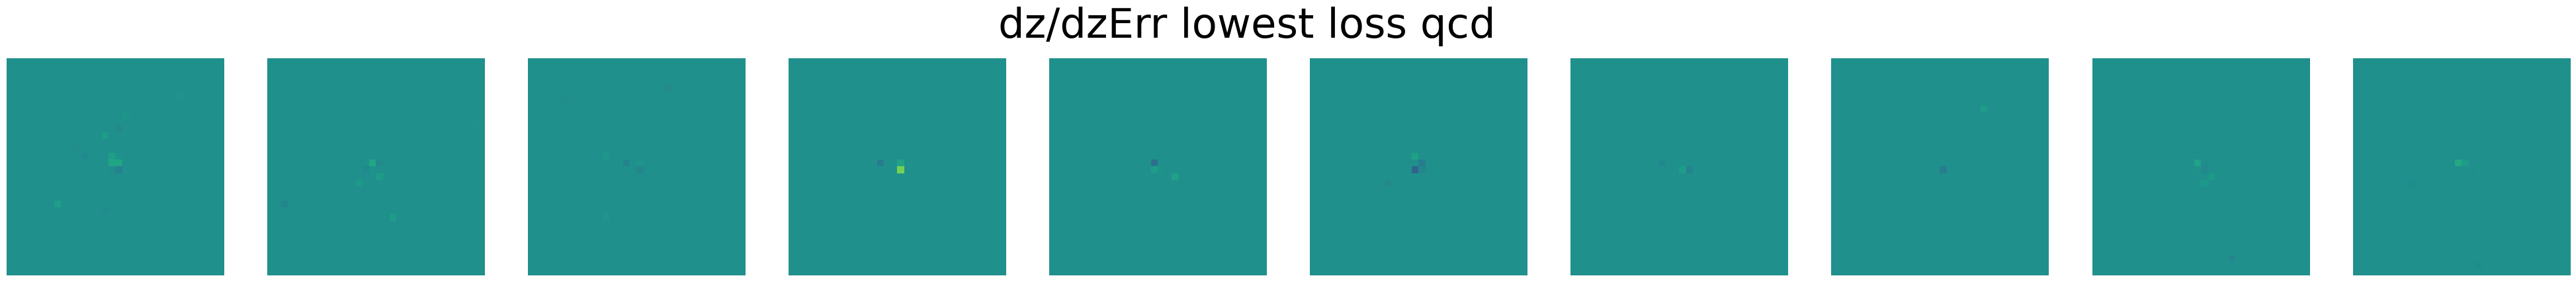

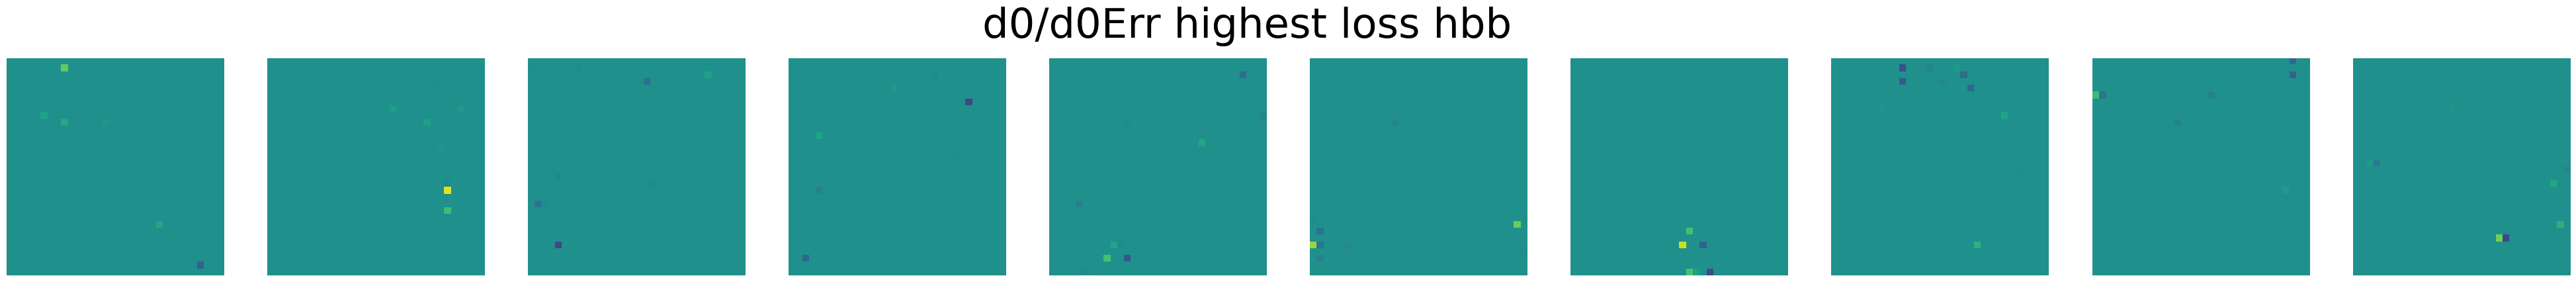

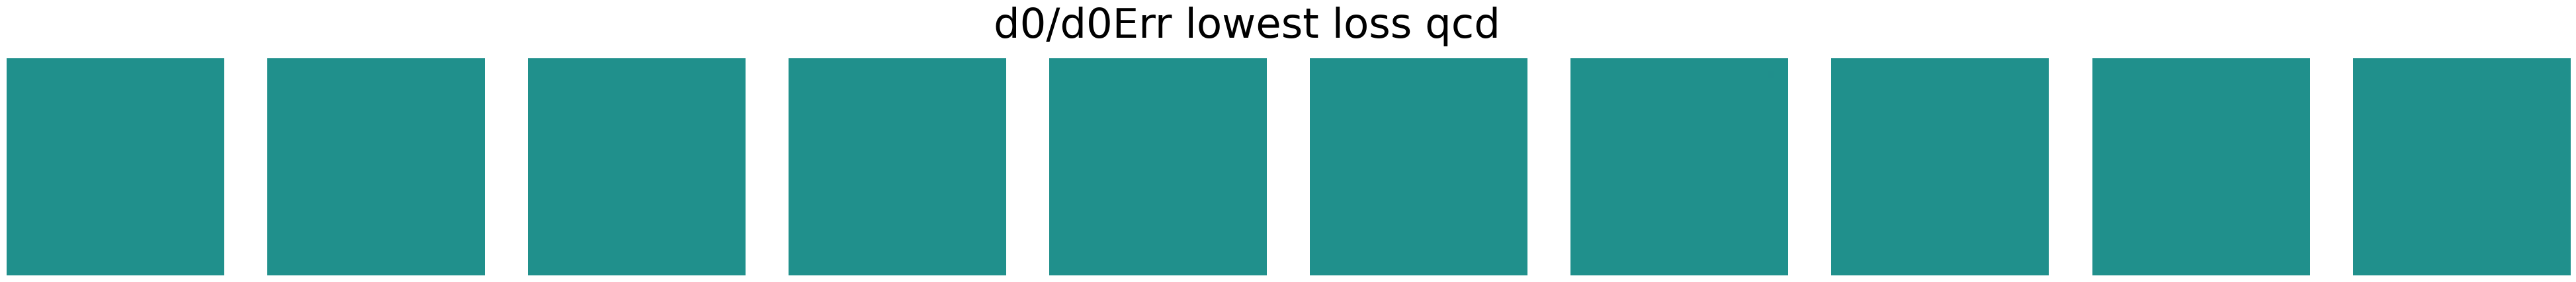

In [39]:
plot_extrema_2(dz_anom_plots, norm, "dz/dzErr highest loss hbb")
plot_extrema_2(dz_background_plots, norm, "dz/dzErr lowest loss qcd")
plot_extrema_2(d0_anom_plots, norm, "d0/d0Err highest loss hbb")
plot_extrema_2(d0_background_plots, norm, "d0/d0Err lowest loss qcd")

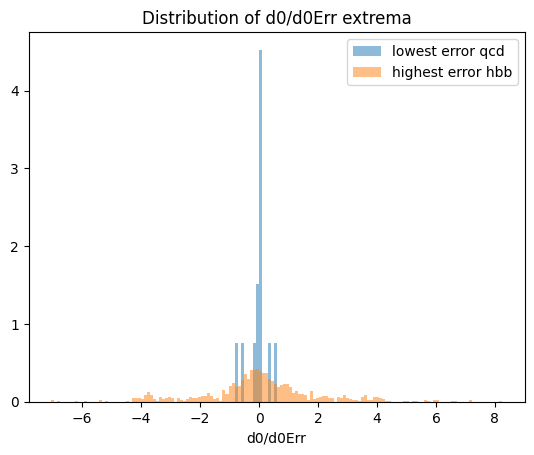

In [40]:
d0_background_vals2 = [p for sublist in d0_background_vals for p in sublist]
d0_anom_vals2 = [p for sublist in d0_anom_vals for p in sublist]

plot_property_distribution2(d0_background_vals2, d0_anom_vals2, 'd0/d0Err', 'lowest error qcd', 'highest error hbb')